In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [2]:
sng_tesla_ea = src.graph.graph_from_json('Outputs/sng_tesla_ea.json')
sng_tesla = src.graph.graph_from_json('Outputs/sng_tesla.json')
sng_other = src.graph.graph_from_json('Outputs/sng_other.json')

graphs = [sng_tesla_ea, sng_tesla, sng_other]

In [3]:
def adjusted_rta(values, vehicle_kw):

    rta = src.routing.road_trip_accessibility(values)

    end_soc = src.routing.road_trip_accessibility(
        values, field = 'soc'
    )

    excess_chg_time = (end_soc - .1) * vehicle_kw['capacity'] / vehicle_kw['charge_rate']

    return (rta - excess_chg_time) / 3600

In [4]:
deep_reload(src)

seed = 123853692
rng = np.random.default_rng(seed)

vehicle_param = src.experiments.default_vehicle_param
station_param = src.experiments.default_station_param

In [5]:
deep_reload(src)

graph_index, vehicle_kw, station_kw = src.experiments.generate_case(
    graphs, vehicle_param, station_param, rng = rng,
)


graph_index, vehicle_kw, station_kw

(2,
 {'capacity': 322794362.4249195,
  'charge_rate': 117278.59890453267,
  'risk_attitude': array([0.36159926, 0.56159926]),
  'cases': 1,
  'charge_target_soc': 0.8,
  'soc_bounds': (0.1, 1),
  'efficiency': 550},
 {'reliability': 0.9783677954253022, 'base_delay': 60, 'cases': 100})

In [6]:
vehicle_kw['capacity'] / 550 / 1609, vehicle_kw['charge_rate'] / 1000

(364.76000048016215, 117.27859890453267)

In [10]:
deep_reload(src)

graph_index = 0

t0 = time.time()

vehicle_kw['max_charge_start_soc'] = .5
vehicle_kw['cases'] = 1

costs0, values0, paths0 = src.experiments.run_case(
    graphs[graph_index], vehicle_kw, station_kw, method = 'dijkstra', seed = seed,
)

print(time.time() - t0)

13.026498794555664


In [11]:
deep_reload(src)

print(
    src.routing.road_trip_accessibility(values0, field = 'soc'),
    src.routing.road_trip_accessibility(values0, field = 'driving_time') / 3600,
    src.routing.road_trip_accessibility(values0, field = 'time') / 3600,
    adjusted_rta(values0, vehicle_kw)
)

0.3783002468521092 5.445588361561283 5.707374941992458 5.494601086535744


In [7]:
deep_reload(src)

graph_index = 1

vehicle_kw['max_charge_start_soc'] = .5
vehicle_kw['cases'] = 100

t0 = time.time()

costs1, values1, paths1 = src.experiments.run_case(
    graphs[graph_index], vehicle_kw, station_kw, method = 'dijkstra', seed = seed,
)

print(time.time() - t0)

91.35134291648865


In [8]:
deep_reload(src)

print(
    src.routing.road_trip_accessibility(values1, field = 'soc'),
    src.routing.road_trip_accessibility(values1, field = 'driving_time') / 3600,
    src.routing.road_trip_accessibility(values1, field = 'time') / 3600,
    adjusted_rta(values1, vehicle_kw)
)

0.38295900920138043 5.447436094014016 5.712954924264493 5.496619222068786


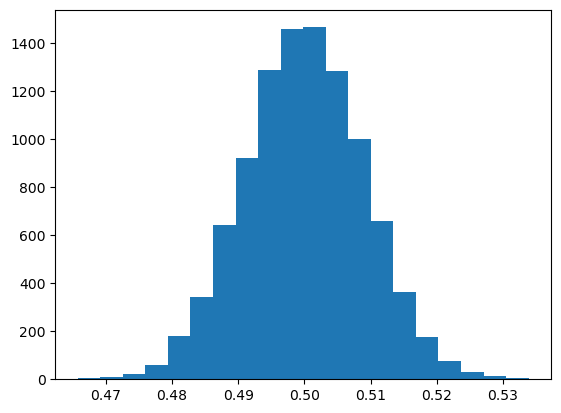

In [18]:
n = 10000
x = np.zeros(n)

iterations = 1000

for idx in range(iterations):

    x += np.random.rand(n)
    
x /= iterations

_ = plt.hist(x, 20)

In [32]:
deep_reload(src)

graph_index = 2

costs2, values2, paths2 = src.experiments.run_case(
    graphs[graph_index], vehicle_kw, station_kw, method = 'bellman'
)

In [33]:
print(
    src.routing.road_trip_accessibility(values2, field = 'soc'),
    src.routing.road_trip_accessibility(values2, field = 'time') / 3600,
    adjusted_rta(values2, vehicle_kw)
)

0.3453049311313936 7.598406163900642 7.410858806146746


In [14]:
cities = [k for k, v in sng_tesla_ea._node.items() if v['type'] == 'city']

for city in cities:

    print(
        city,
        src.routing.specific_road_trip_accessibility(
            values0[city], field = 'time'
        ) / 3600,
        src.routing.specific_road_trip_accessibility(
            values1[city], field = 'time'
        ) / 3600,
    )

Crescent City 8.450190092491574 8.455154244443651
Yreka 6.65910421340013 6.674476804578497
Redding 5.308798320411622 5.314093829836515
Chico 4.785433359565547 4.789535529564352
I-80 to Reno (State Line) 5.554418970994453 5.558521140993258
Sacramento 4.026587483704663 4.027268973059186
Stockton 3.8955392914341656 3.9033355918347583
San Francisco 4.2975903606681385 4.308446120381348
San Jose 4.291384454387818 4.298473337430224
Fresno 4.2318223194734355 4.239242516238464
I-15 to Las Vegas (State Line) 7.944401349986887 7.948073402810295
Bakersfield 4.750886451625173 4.757913017689481
Los Angeles 5.579081032111149 5.579794293049523
I-10 to Phoenix (State Line) 8.581562652710405 8.583457252845264
San Diego 7.253823776921696 7.256428542746862


In [15]:
cities = [k for k, v in sng_tesla_ea._node.items() if v['type'] == 'city']

for city in cities:

    print(
        city,
        src.routing.specific_road_trip_accessibility(
            values0[city], field = 'routing_time'
        ) / 3600,
        src.routing.specific_road_trip_accessibility(
            values1[city], field = 'routing_time'
        ) / 3600,
    )

Crescent City 8.948571489105527 8.949972346884143
Yreka 7.0000621639062555 7.0539083310318915
Redding 5.530820135049137 5.532585351806437
Chico 5.014325687458347 5.015745182414055
I-80 to Reno (State Line) 5.8008514784488385 5.802270973404548
Sacramento 4.232880828435151 4.2335197632163135
Stockton 4.035374752373222 4.046751716160893
San Francisco 4.501344326367869 4.501973961564263
San Jose 4.4689214095940155 4.468902810424478
Fresno 4.430829359631203 4.432230255417375
I-15 to Las Vegas (State Line) 8.349401813917224 8.355106933194465
Bakersfield 4.976078349096415 4.976050409050312
Los Angeles 5.901093673943836 5.900235889510582
I-10 to Phoenix (State Line) 9.134870492060811 9.134851873315789
San Diego 7.691632968587438 7.6924721538484695


In [16]:
cities = [k for k, v in sng_tesla_ea._node.items() if v['type'] == 'city']

for city in cities:

    print(
        city,
        src.routing.specific_road_trip_accessibility(
            values0[city], field = 'driving_time'
        ) / 3600,
        src.routing.specific_road_trip_accessibility(
            values1[city], field = 'driving_time'
        ) / 3600,
    )

Crescent City 7.959014333351831 7.960433830521329
Yreka 6.323000213443967 6.324774772218523
Redding 5.062082060069566 5.0638566188441265
Chico 4.5976779211529255 4.599097418322423
I-80 to Reno (State Line) 5.3321227214914755 5.333542218660974
Sacramento 3.8682834686147216 3.8689529657842185
Stockton 3.7749605898730914 3.7863468554593585
San Francisco 4.13673766696267 4.137407164132166
San Jose 4.156416961279463 4.156416961279463
Fresno 4.118324887381142 4.119744384550639
I-15 to Las Vegas (State Line) 7.516047738603998 7.521811359242617
Bakersfield 4.611483592102348 4.611483592102348
Los Angeles 5.328193665593669 5.3273451807451835
I-10 to Phoenix (State Line) 8.041151484395238 8.041151484395238
San Diego 6.85832811910313 6.859176603951615


In [32]:
paths = paths0

stations = []

for pathcol in paths.values():
    # print(pathcol)
    for path in pathcol.values():
        # print(path)
    
        # break
    
        if path[-1] in cities:
    
            stations.extend(path[1:-1])

u0, c0 = np.unique(stations, return_counts = True)
n0 = np.array([sng_tesla_ea._node[n].get('network', '') for n in u0])
# d0 = np.array([sng_tesla_ea._node[n]['station'].delay_time for n in u0])
u0, n0, d0, c0, len(c0)

(array(['San Jose', 'station_1004', 'station_1005', 'station_1006',
        'station_102', 'station_103', 'station_1075', 'station_1105',
        'station_112', 'station_1126', 'station_1130', 'station_1131',
        'station_1144', 'station_116', 'station_123', 'station_124',
        'station_126', 'station_140', 'station_149', 'station_1537',
        'station_1538', 'station_154', 'station_1540', 'station_1558',
        'station_157', 'station_167', 'station_1672', 'station_1691',
        'station_1716', 'station_179', 'station_1799', 'station_1837',
        'station_184', 'station_1845', 'station_1867', 'station_1899',
        'station_193', 'station_194', 'station_202', 'station_210',
        'station_219', 'station_230', 'station_237', 'station_246',
        'station_258', 'station_261', 'station_274', 'station_284',
        'station_301', 'station_315', 'station_318', 'station_322',
        'station_323', 'station_347', 'station_417', 'station_420',
        'station_422', 'statio

In [33]:
paths = paths1

stations = []

for pathcol in paths.values():
    # print(pathcol)
    for path in pathcol.values():
        # print(path)
    
        # break
    
        if path[-1] in cities:
    
            stations.extend(path[1:-1])
            
u1, c1 = np.unique(stations, return_counts = True)
n1 = np.array([sng_tesla_ea._node[n]['network'] for n in u1])
# d1 = np.array([sng_tesla_ea._node[n]['station'].delay_time for n in u1])
u1, n1, d1, c1, len(c1)

(array(['station_1004', 'station_1005', 'station_1006', 'station_102',
        'station_1022', 'station_103', 'station_1075', 'station_1105',
        'station_112', 'station_1126', 'station_1130', 'station_1131',
        'station_1144', 'station_116', 'station_123', 'station_124',
        'station_126', 'station_133', 'station_136', 'station_138',
        'station_140', 'station_149', 'station_1537', 'station_1538',
        'station_154', 'station_1540', 'station_1554', 'station_1558',
        'station_157', 'station_167', 'station_1691', 'station_1799',
        'station_1837', 'station_184', 'station_1867', 'station_1899',
        'station_230', 'station_237', 'station_258', 'station_261',
        'station_274', 'station_322', 'station_323', 'station_417',
        'station_420', 'station_425', 'station_469', 'station_489',
        'station_494', 'station_496', 'station_500', 'station_552',
        'station_724', 'station_738', 'station_809', 'station_827',
        'station_841', 'stat

In [28]:
sum([u in u0 for u in u1]), sum([u in u1 for u in u0]),

(56, 56)

In [22]:
paths

{'Crescent City': {'Crescent City': ['Crescent City'],
  'Yreka': ['Crescent City', 'Yreka'],
  'Redding': ['Crescent City', 'Redding'],
  'Chico': ['Crescent City', 'Chico'],
  'I-80 to Reno (State Line)': ['Crescent City', 'I-80 to Reno (State Line)'],
  'Sacramento': ['Crescent City', 'Sacramento'],
  'Stockton': ['Crescent City', 'Stockton'],
  'San Francisco': ['Crescent City', 'San Francisco'],
  'San Jose': ['Crescent City', 'San Jose'],
  'Fresno': ['Crescent City', 'Fresno'],
  'I-15 to Las Vegas (State Line)': ['Crescent City',
   'I-15 to Las Vegas (State Line)'],
  'Bakersfield': ['Crescent City', 'Bakersfield'],
  'Los Angeles': ['Crescent City', 'Los Angeles'],
  'I-10 to Phoenix (State Line)': ['Crescent City',
   'I-10 to Phoenix (State Line)'],
  'San Diego': ['Crescent City', 'San Diego'],
  'station_0': ['Crescent City', 'station_0'],
  'station_1416': ['Crescent City', 'station_1416'],
  'station_2': ['Crescent City', 'station_2'],
  'station_3': ['Crescent City', '

In [106]:
pprint({k: v['time'].mean() / 3600 for k, v in values['Fresno'].items() if 'station' not in k})

{'Bakersfield': 1.6082676698301694,
 'Chico': 4.23047250666002,
 'Crescent City': 12.605738955488931,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 10.647205294705318,
 'I-15 to Las Vegas (State Line)': 5.727073083166839,
 'I-80 to Reno (State Line)': 4.5377698863636535,
 'Los Angeles': 3.263417207792208,
 'Redding': 5.11872446997449,
 'Sacramento': 2.6713354700854763,
 'San Diego': 5.252874417249402,
 'San Francisco': 2.9443037864912918,
 'San Jose': 2.513857364857367,
 'Stockton': 1.9591595904095913,
 'Yreka': 10.610469062187807}


In [107]:
pprint({k: v for k, v in paths['Fresno'].items() if 'station' not in k})

{'Bakersfield': ['Fresno', 'Bakersfield'],
 'Chico': ['Fresno', 'Chico'],
 'Crescent City': ['Fresno', 'Crescent City'],
 'Fresno': ['Fresno'],
 'I-10 to Phoenix (State Line)': ['Fresno', 'I-10 to Phoenix (State Line)'],
 'I-15 to Las Vegas (State Line)': ['Fresno', 'I-15 to Las Vegas (State Line)'],
 'I-80 to Reno (State Line)': ['Fresno', 'I-80 to Reno (State Line)'],
 'Los Angeles': ['Fresno', 'Los Angeles'],
 'Redding': ['Fresno', 'Redding'],
 'Sacramento': ['Fresno', 'Sacramento'],
 'San Diego': ['Fresno', 'San Diego'],
 'San Francisco': ['Fresno', 'San Francisco'],
 'San Jose': ['Fresno', 'San Jose'],
 'Stockton': ['Fresno', 'Stockton'],
 'Yreka': ['Fresno', 'Yreka']}


In [7]:
graph_index, vehicle_kw, station_kw, costs, values, paths = pkl.load(
    open('Outputs/Random_Experiment/case_654.pkl', 'rb'),
)

In [8]:
src.routing.road_trip_accessibility(values) / 3600

5.766728458596094

In [9]:
graph_index, vehicle_kw, station_kw

(1,
 {'capacity': 388048156.9757598,
  'charge_rate': 74122.73534740988,
  'risk_attitude': array([0.57458613, 0.81189887]),
  'cases': 1,
  'charge_target_soc': 0.8,
  'soc_bounds': (0.1, 1),
  'efficiency': 550},
 {'reliability': 0.7267084207813376, 'base_delay': 60, 'cases': 100})